# Analysis of Spanish High Speed Rail Pricing

For this project, I will investigate ticket price data for the Spanish high speed rail system, RENFE. The purpose of this analysis will be to make recommendations to consumers about purchasing train tickets. This idea for this project came from the following Kaggle dataset: https://www.kaggle.com/thegurus/spanish-high-speed-rail-system-ticket-pricing

## Loading the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
renfe = pd.read_csv("./renfe.csv")

In [3]:
renfe.drop(columns=["Unnamed: 0"], inplace=True)

## Inspecting the Data

In [4]:
renfe.shape

(2579771, 9)

In [5]:
renfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579771 entries, 0 to 2579770
Data columns (total 9 columns):
insert_date    object
origin         object
destination    object
start_date     object
end_date       object
train_type     object
price          float64
train_class    object
fare           object
dtypes: float64(1), object(8)
memory usage: 177.1+ MB


In [6]:
renfe.head()

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo
2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo
3,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.40,Preferente,Promo
4,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:30:00,2019-05-29 11:14:00,ALVIA,NaN,Turista,Promo


### Investigate Null Values

In [7]:
renfe.isnull().sum()

insert_date         0
origin              0
destination         0
start_date          0
end_date            0
train_type          0
price          310681
train_class      9664
fare             9664
dtype: int64

In [8]:
renfe[renfe["train_class"].isnull()].isnull().sum()

insert_date       0
origin            0
destination       0
start_date        0
end_date          0
train_type        0
price          9664
train_class    9664
fare           9664
dtype: int64

We can see that there are many null entries in the price column. These null values represent entries where the ticket was not available for sale at the time that the entry was scraped. In other words, these entries represent tickets that are sold out. This is potentially useful information, so I'll keep these entries.

There are also a fair amount of null values in the train_class and fare columns. All of these null values are entries where the price is also null. I'm not sure why there is such a small proportion of the null price entries that also have null values for the other columns. Because I don't know how to interpret these entries, I'll remove them from the data set.

In [9]:
renfe.drop(renfe[renfe["train_class"].isnull()].index, inplace=True)

In [10]:
renfe = renfe.reset_index(drop=True)

In [11]:
renfe.isnull().sum()

insert_date         0
origin              0
destination         0
start_date          0
end_date            0
train_type          0
price          301017
train_class         0
fare                0
dtype: int64

### Feature Engineering

In this section, I'll update the dataframe to include some additional columns that I think are warranted for this analysis.

Firstly, I'll add a column to include the route of the train trip.

In [12]:
renfe["origin"].value_counts()

MADRID        1355738
BARCELONA      405536
SEVILLA        395799
VALENCIA       322445
PONFERRADA      90589
Name: origin, dtype: int64

In [13]:
renfe["destination"].value_counts()

MADRID        1214369
BARCELONA      479185
SEVILLA        412366
VALENCIA       399214
PONFERRADA      64973
Name: destination, dtype: int64

In [14]:
renfe["route"] = renfe["origin"] + "-" + renfe["destination"]

In [15]:
renfe["route"].value_counts()

MADRID-BARCELONA     479185
MADRID-SEVILLA       412366
BARCELONA-MADRID     405536
MADRID-VALENCIA      399214
SEVILLA-MADRID       395799
VALENCIA-MADRID      322445
PONFERRADA-MADRID     90589
MADRID-PONFERRADA     64973
Name: route, dtype: int64

Changing date columns to datetime format:

In [16]:
renfe["insert_date"] = pd.to_datetime(renfe["insert_date"])
renfe["start_date"] = pd.to_datetime(renfe["start_date"])
renfe["end_date"] = pd.to_datetime(renfe["end_date"])

I'll also add columns to reflect elements of the start_date column. For example, it would be useful to have a column dedicated to a given train trip's day of the week, time of day, and month. This dataset only includes information on train trips that depart in between April and July of 2019, so there is no need to include the year of the trip.

In [17]:
renfe["trip_duration"] = renfe["end_date"] - renfe["start_date"]

# Convert duration to integer value in minutes
renfe["trip_duration"] = renfe["trip_duration"].apply(lambda x: int(x.seconds / 60))

It will be useful to add a column for the number of days in between the departure and the date of the listing.

In [18]:
renfe["days_in_advance"] = \
renfe["start_date"].apply(lambda x: x.date()) - renfe["insert_date"].apply(lambda x: x.date())

# Changing datatype to integer number of days:
renfe["days_in_advance"] = renfe["days_in_advance"].apply(lambda x: x.days)

In [19]:
renfe.drop(renfe[renfe["insert_date"] > renfe["start_date"]].index, inplace=True)
renfe = renfe.reset_index(drop=True)

The duration column negates the need to include the end_date column, so I'll drop that column.

In [20]:
renfe.drop(columns=["end_date"], inplace=True)

In [21]:
renfe.head()

,insert_date,origin,destination,start_date,train_type,price,train_class,fare,route,trip_duration,days_in_advance
0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,AV City,38.55,Turista,Promo,MADRID-SEVILLA,176,40
1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,AVE,53.40,Turista,Promo,MADRID-SEVILLA,152,40
2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,AVE,47.30,Turista,Promo,MADRID-SEVILLA,141,40
3,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:00:00,AVE,69.40,Preferente,Promo,MADRID-SEVILLA,152,40
4,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:30:00,ALVIA,NaN,Turista,Promo,MADRID-SEVILLA,164,40


In [22]:
renfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2566671 entries, 0 to 2566670
Data columns (total 11 columns):
insert_date        datetime64[ns]
origin             object
destination        object
start_date         datetime64[ns]
train_type         object
price              float64
train_class        object
fare               object
route              object
trip_duration      int64
days_in_advance    int64
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 215.4+ MB


In [23]:
renfe["depart_date"] = renfe["start_date"].apply(lambda x: x.date())

renfe["depart_hour"] = renfe["start_date"].apply(lambda x: x.hour)

renfe["depart_month"] = renfe["start_date"].apply(lambda x: x.month)

renfe["depart_weekday"] = renfe["start_date"].apply(lambda x: x.weekday()) # 0: Monday, ... , 6: Sunday

In [24]:
renfe["listing_date"] = renfe["insert_date"].apply(lambda x: x.date())

renfe["listing_hour"] = renfe["insert_date"].apply(lambda x: x.hour)

renfe["listing_month"] = renfe["insert_date"].apply(lambda x: x.month)

renfe["listing_weekday"] = renfe["insert_date"].apply(lambda x: x.weekday()) # 0: Monday, ... , 6: Sunday

In [25]:
renfe.head()

,insert_date,origin,destination,start_date,train_type,price,train_class,fare,route,trip_duration,days_in_advance,depart_date,depart_hour,depart_month,depart_weekday,listing_date,listing_hour,listing_month,listing_weekday
0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,AV City,38.55,Turista,Promo,MADRID-SEVILLA,176,40,2019-05-29,6,5,2,2019-04-19,5,4,4
1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,AVE,53.40,Turista,Promo,MADRID-SEVILLA,152,40,2019-05-29,7,5,2,2019-04-19,5,4,4
2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,AVE,47.30,Turista,Promo,MADRID-SEVILLA,141,40,2019-05-29,7,5,2,2019-04-19,5,4,4
3,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:00:00,AVE,69.40,Preferente,Promo,MADRID-SEVILLA,152,40,2019-05-29,8,5,2,2019-04-19,5,4,4
4,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:30:00,ALVIA,NaN,Turista,Promo,MADRID-SEVILLA,164,40,2019-05-29,8,5,2,2019-04-19,5,4,4


In [26]:
renfe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2566671 entries, 0 to 2566670
Data columns (total 19 columns):
insert_date        datetime64[ns]
origin             object
destination        object
start_date         datetime64[ns]
train_type         object
price              float64
train_class        object
fare               object
route              object
trip_duration      int64
days_in_advance    int64
depart_date        object
depart_hour        int64
depart_month       int64
depart_weekday     int64
listing_date       object
listing_hour       int64
listing_month      int64
listing_weekday    int64
dtypes: datetime64[ns](2), float64(1), int64(8), object(8)
memory usage: 372.1+ MB


In [27]:
renfe["route"].value_counts()

MADRID-BARCELONA     478605
MADRID-SEVILLA       411845
BARCELONA-MADRID     404947
MADRID-VALENCIA      398741
SEVILLA-MADRID       395250
VALENCIA-MADRID      321952
PONFERRADA-MADRID     90444
MADRID-PONFERRADA     64887
Name: route, dtype: int64

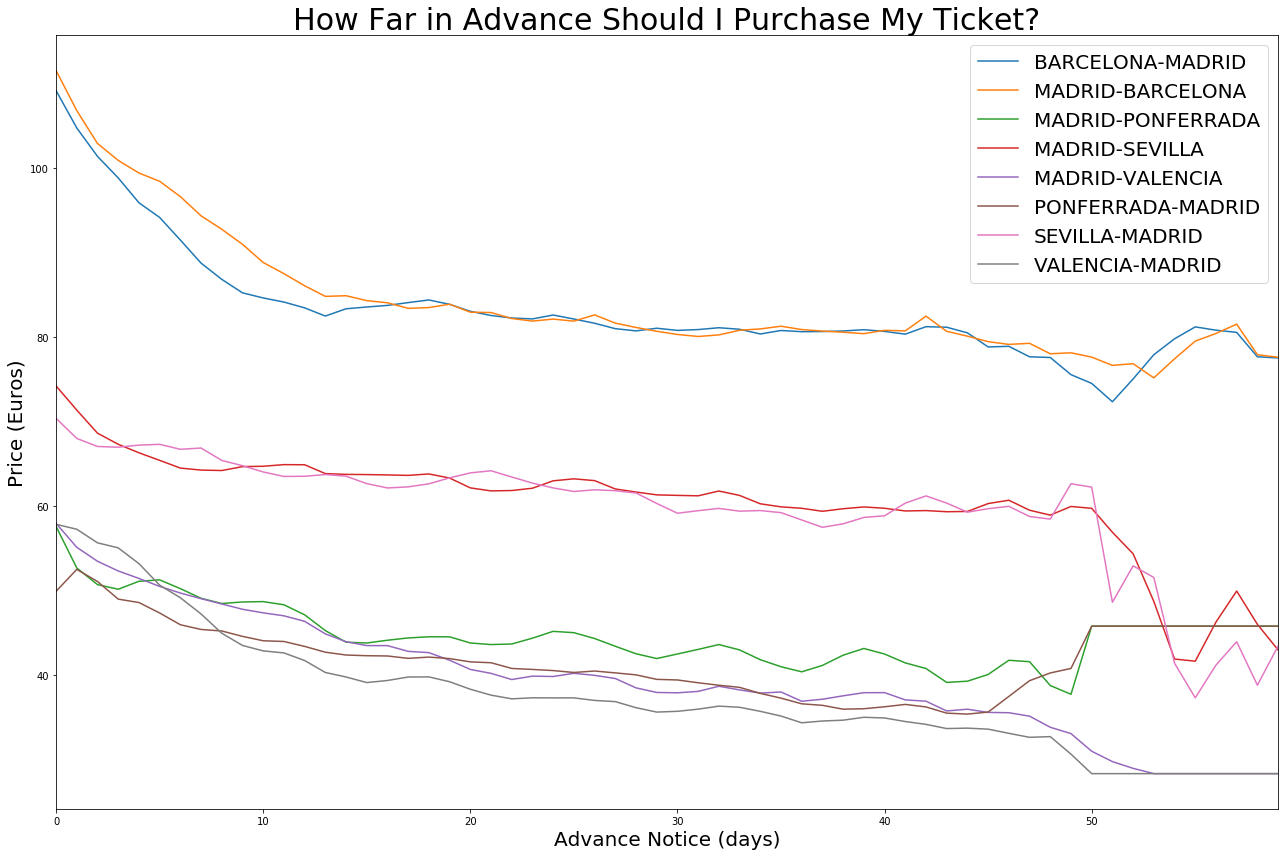

In [28]:
fig, ax = plt.subplots(figsize = (18, 12))

renfe.groupby(["route", "days_in_advance"]).mean().unstack(level=0)["price"].plot(ax=ax)

plt.title("How Far in Advance Should I Purchase My Ticket?", fontsize = 30)
plt.xlabel("Advance Notice (days)", fontsize = 20)
plt.ylabel("Price (Euros)", fontsize = 20)
plt.legend(fontsize = 20)
plt.tight_layout()
plt.show()

It is clear from this data that it is generally best to purchase tickets in advance if possible. Except for the Madrid/Ponferrada connection, the lowest prices are available 50+ days in advance. In general, there is a steady increase in price as the date of travel approaches. This increase is especially pronounced in the last week or two before the trip. So, it would be recommended that travelers purchase tickets as far in advance as possible and certainly more than 10 days in advance if possible. 

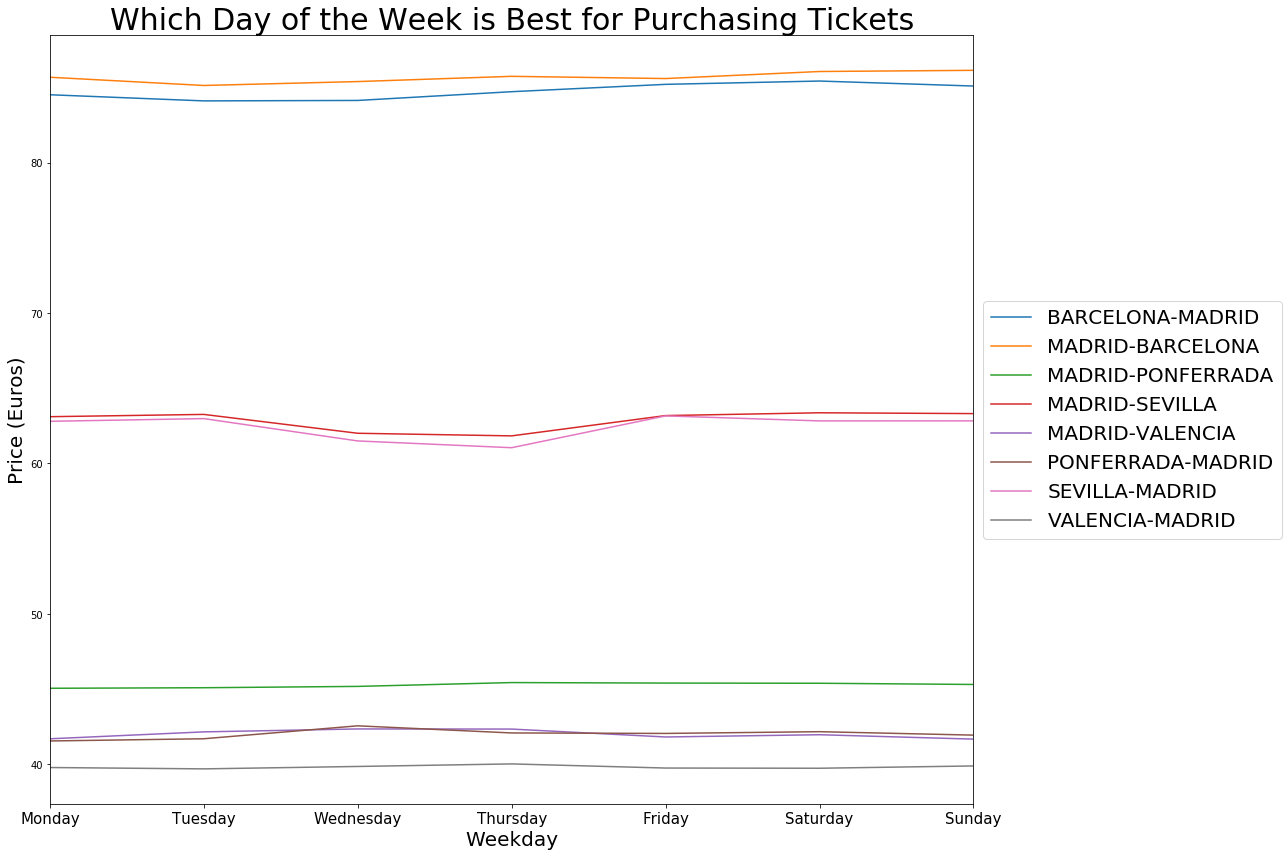

In [29]:
fig, ax = plt.subplots(figsize = (18, 12))

renfe.groupby(["route", "listing_weekday"]).mean().unstack(level=0)["price"].plot(ax=ax)

plt.title("Which Day of the Week is Best for Purchasing Tickets", fontsize = 30)
plt.xlabel("Weekday", fontsize = 20)
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6], 
           labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
           fontsize = 15)
plt.ylabel("Price (Euros)", fontsize = 20)
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

There does not seem to be a significant relationship between ticket price and day of the week. It seems that any day is as good as the next for purchasing tickets.

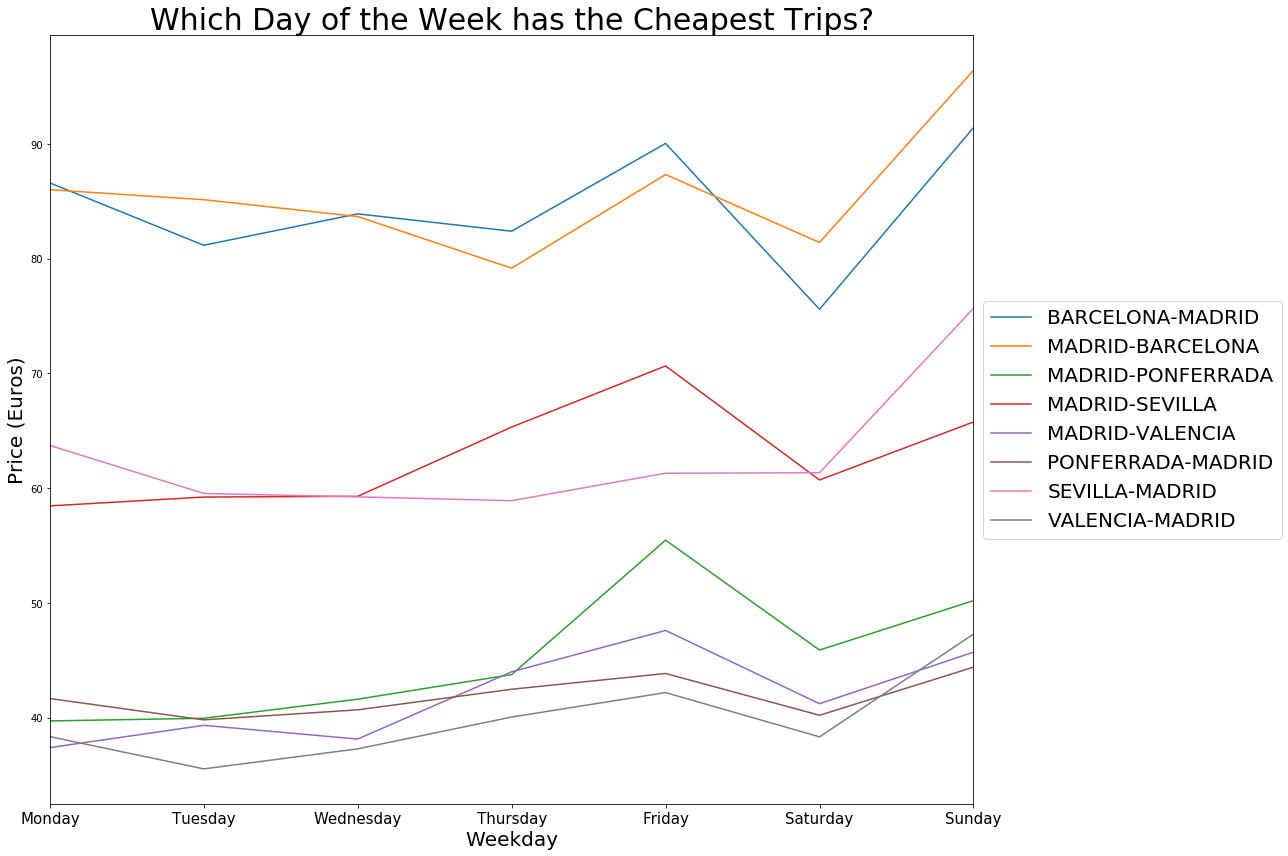

In [30]:
fig, ax = plt.subplots(figsize = (18, 12))

renfe.groupby(["route", "depart_weekday"]).mean().unstack(level=0)["price"].plot(ax=ax)

plt.title("Which Day of the Week has the Cheapest Trips?", fontsize = 30)
plt.xlabel("Weekday", fontsize = 20)
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6], 
           labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
           fontsize = 15)
plt.ylabel("Price (Euros)", fontsize = 20)
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

If possible, it is cheapest to plan trips for days of the week besides Friday and Sunday. Those days generally have a pronounced spike in ticket prices for all of the routes. This makes intuitive sense, since many people travel at the beginning and end of the weekend.

In [31]:
renfe["depart_hour"].value_counts()

17    198056
9     195583
16    194796
14    188486
6     182453
7     175525
8     172724
19    166241
12    160914
15    158605
18    147550
11    146379
20    126421
13    114185
21    103287
10    102176
5      15035
2       9175
22      9080
Name: depart_hour, dtype: int64

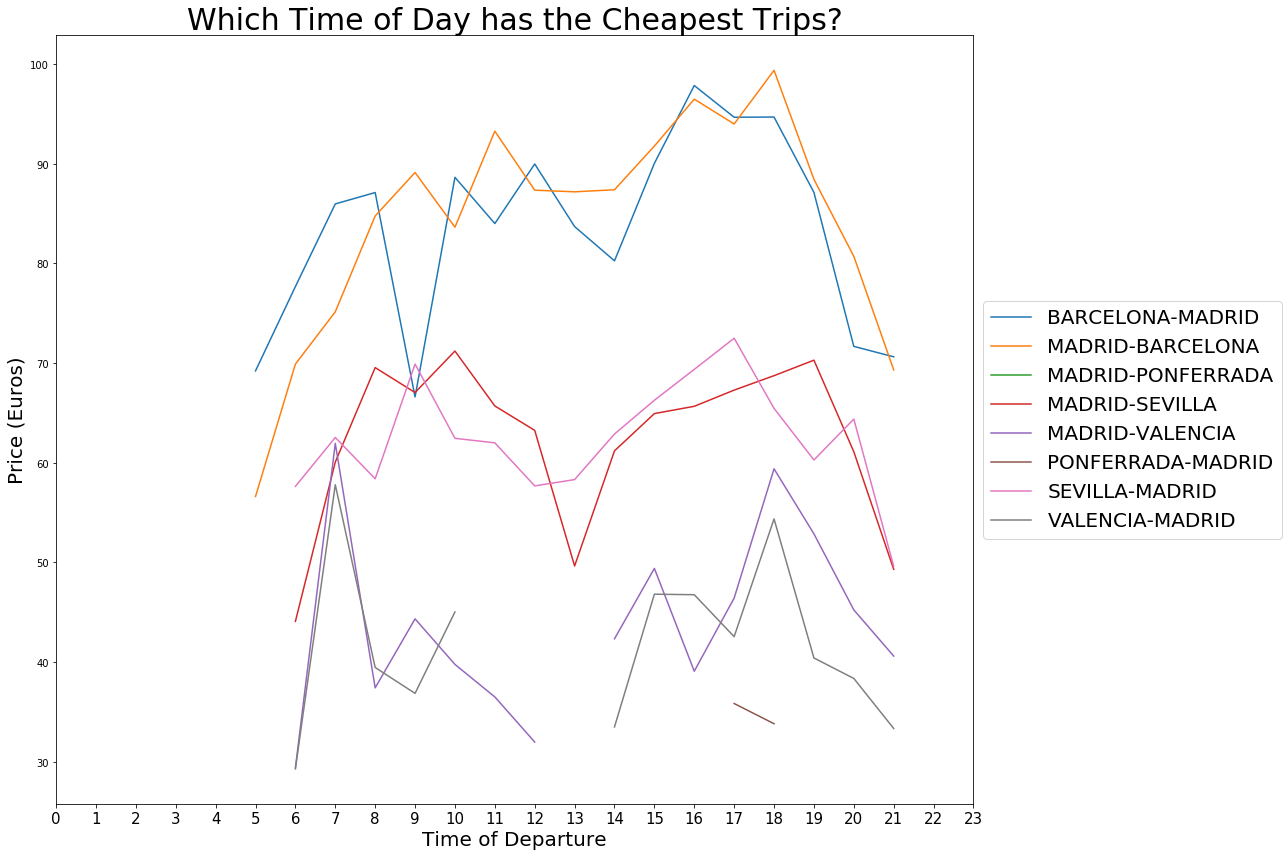

In [32]:
fig, ax = plt.subplots(figsize = (18, 12))

renfe.groupby(["route", "depart_hour"]).mean().unstack(level=0)["price"].plot(ax=ax,)

plt.title("Which Time of Day has the Cheapest Trips?", fontsize = 30)
plt.xlabel("Time of Departure", fontsize = 20)
plt.xticks(ticks = list(range(24)), 
           labels = list(range(24)),
           fontsize = 15)
plt.ylabel("Price (Euros)", fontsize = 20)
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

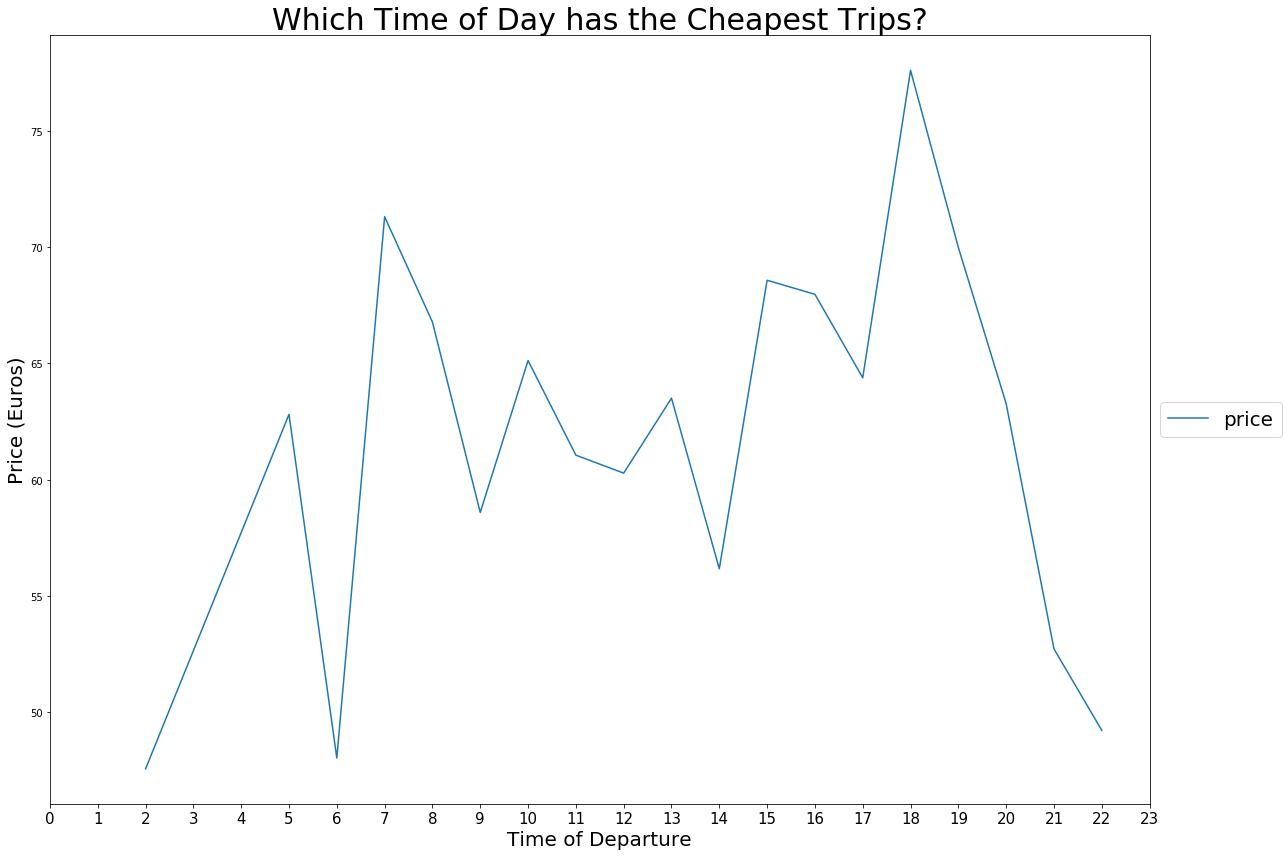

In [33]:
fig, ax = plt.subplots(figsize = (18, 12))

renfe.groupby("depart_hour").mean()["price"].plot(ax=ax,)

plt.title("Which Time of Day has the Cheapest Trips?", fontsize = 30)
plt.xlabel("Time of Departure", fontsize = 20)
plt.xticks(ticks = list(range(24)), 
           labels = list(range(24)),
           fontsize = 15)
plt.ylabel("Price (Euros)", fontsize = 20)
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

Different individual routes have some variability in terms of what departure time has the cheapest tickets. In general, the cheapest prices are for trains that depart in very early hours (before 7 AM) or very late hours after 9 PM). The most expensive tickets are for trains departing during the morning and evening rush hour (about 7-8 AM and 6-7 PM). There is a lull in price for midday departures, so this is the cheapest alternative to the very late and very early trains.

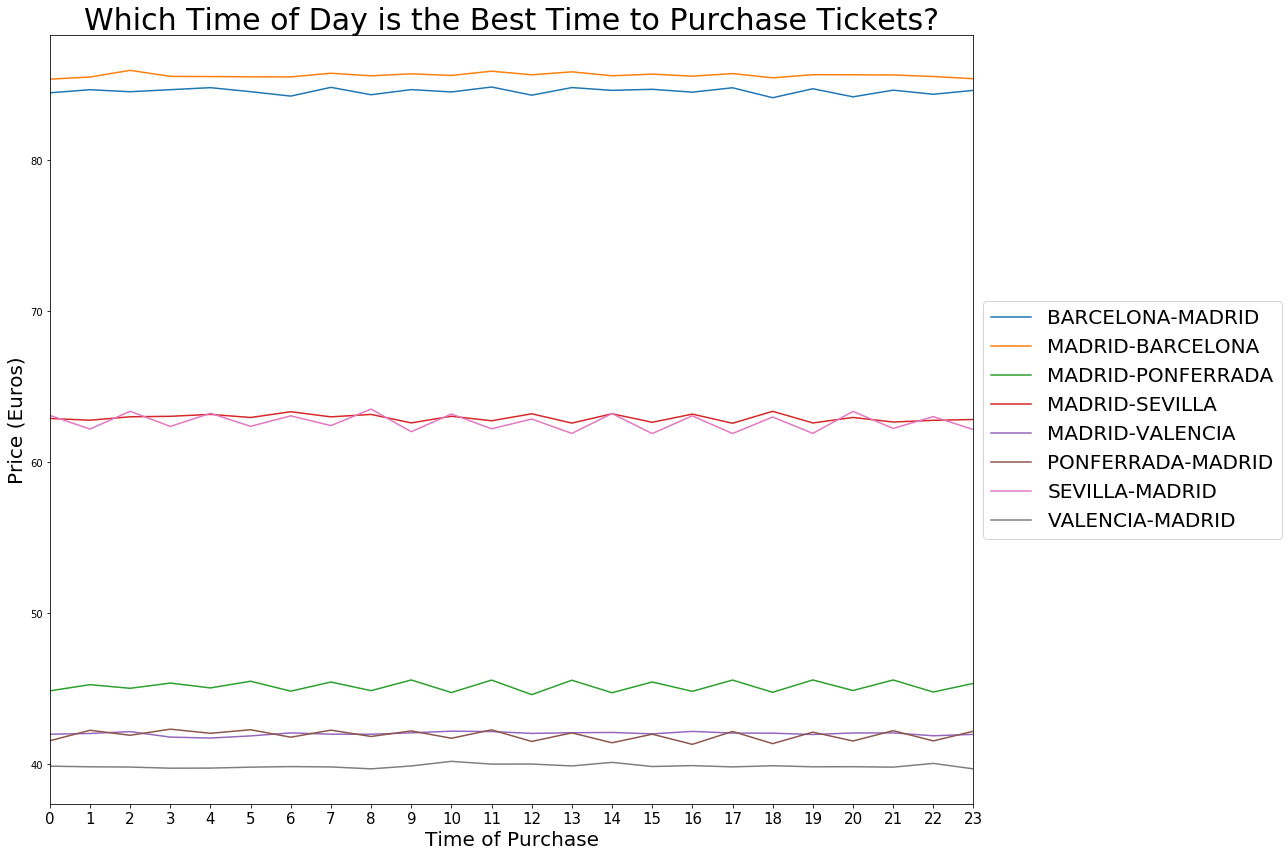

In [33]:
fig, ax = plt.subplots(figsize = (18, 12))

renfe.groupby(["route", "listing_hour"]).mean().unstack(level=0)["price"].plot(ax=ax,)

plt.title("Which Time of Day is the Best Time to Purchase Tickets?", fontsize = 30)
plt.xlabel("Time of Purchase", fontsize = 20)
plt.xticks(ticks = list(range(24)), 
           labels = list(range(24)),
           fontsize = 15)
plt.ylabel("Price (Euros)", fontsize = 20)
ax.legend(fontsize=20, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

There does not seem to be meaningful fluctuation in ticket prices based on hour of the day at the time of purchase.